In [ ]:
# ------------------------------------------------------------
# 🔧 Sistema y utilidades
# ------------------------------------------------------------
import os
import time
import random
import zipfile
import urllib

# ------------------------------------------------------------
# 🔢 Cálculo numérico y científico
# ------------------------------------------------------------
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from scipy.ndimage import gaussian_filter
from math import log10

# ------------------------------------------------------------
# 🎨 Visualización
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 🖼️ Procesamiento de imágenes
# ------------------------------------------------------------
from PIL import Image
from skimage import io
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# 🧠 Machine Learning / Deep Learning
# ------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchsummary import summary

# ------------------------------------------------------------
# 🌀 Librerías adicionales para operadores y modelos avanzados
# ------------------------------------------------------------
from einops import rearrange
from neuralop.models import FNO
from tqdm import tqdm

# ------------------------------------------------------------
# 📦 Librerías del paquete The Well
# ------------------------------------------------------------
from the_well.data import WellDataset
from the_well.benchmark.metrics import VRMSE
from the_well.utils.download import well_download

# ------------------------------------------------------------
# 🖼️ Vision por computador (torchvision)
# ------------------------------------------------------------
from torchvision import datasets, transforms
# ------------------------------------------------------------



In [ ]:
# ------------------------------------------------------------
# 0) Device setup
# ------------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

if device == "cuda":
    print(f"✅ Device: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ CUDA no disponible, usando CPU.")

✅ Device: NVIDIA GeForce RTX 4090


/home/itachi/miniconda3/envs/ml/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


## Exploratory analysis

In [ ]:
# 1) Load dataset
# ------------------------------------------------------------
dataset = WellDataset(
    well_base_path="/home/itachi/Desktop/msc/data/datasets",
    well_dataset_name="active_matter",
    well_split_name="train",
    n_steps_input=81,
    n_steps_output=0,
    use_normalization=True,

)

print(len(dataset))



175


In [ ]:
print(len(dataset))
item = dataset[0]
print(item['input_fields'].shape)

175
torch.Size([81, 256, 256, 11])


In [ ]:
dataset.metadata.field_names

{0: ['concentration'],
 1: ['velocity_x', 'velocity_y'],
 2: ['D_xx', 'D_xy', 'D_yx', 'D_yy', 'E_xx', 'E_xy', 'E_yx', 'E_yy']}

In [ ]:
item = dataset[0]
print(item.keys())
print(item['input_fields'].shape)

dict_keys(['input_fields', 'constant_scalars', 'boundary_conditions', 'space_grid', 'input_time_grid'])
torch.Size([81, 256, 256, 11])


In [ ]:
idx = np.arange(len(dataset))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, shuffle=True)



DIVISION TRAN/TEST DATA

In [ ]:
print(train_idx.shape, test_idx.shape)

(140,) (35,)


TRAIN DATA

In [ ]:
print(train_idx)

[118 143 164  38 135 104  67 148   2  98 152 159  75 108  26 161  90 115
  69  36  85  22 144  96  68 168  11  97  76   6  27  82   4  32  93 120
 166  10 171 122   0 132 124  64  44  95  28  40 125  25  23 142  81  79
  84  39 100  86 119 170 147  47  94 133 163  61  73  33 123 136 137  62
 173 111 114 105  53   5 157   3 162  49  35  80  77  34  46   7  43  70
 140 110  91  83 154 158  89   8  13  59 150 131  17  72 153 134 146 160
  63  54 107  50 172  58  48  88  21  57 169 129  37 165   1  52 149 130
 151 103  99 116  87  74 121 174  20  71 106  14  92 102]


EXPLORATORY DATA

torch.Size([81, 256, 256, 11])


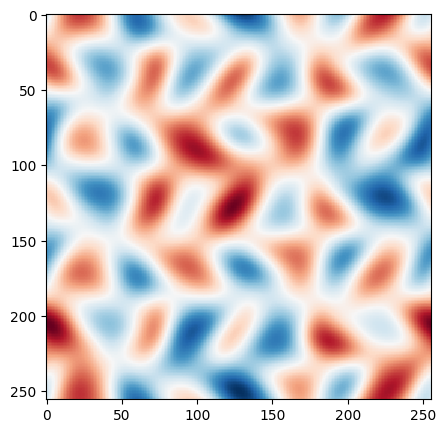

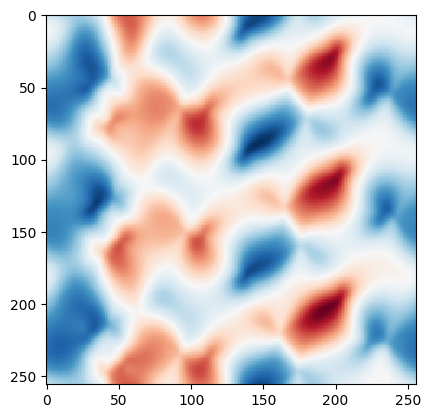

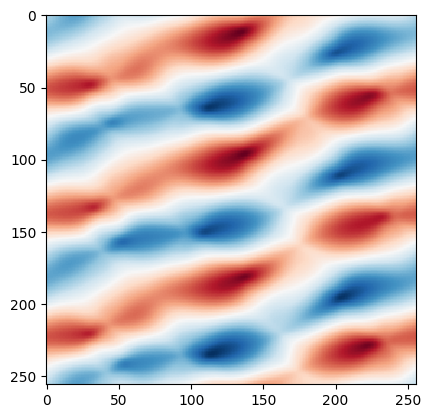

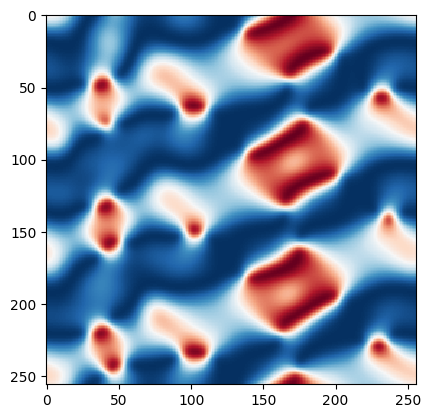

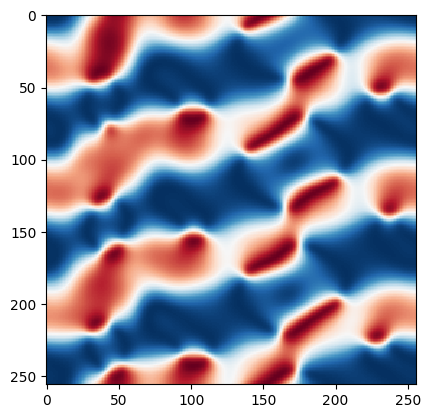

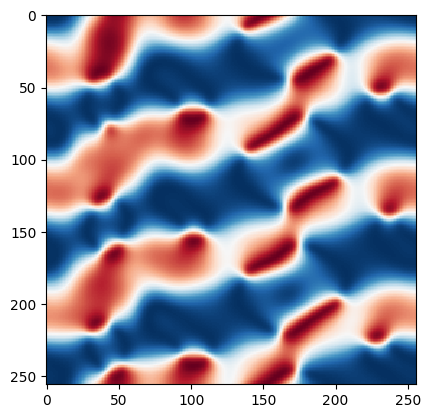

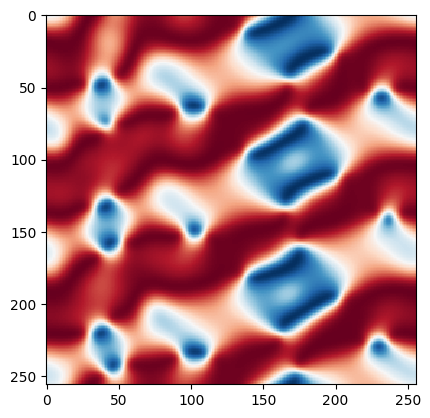

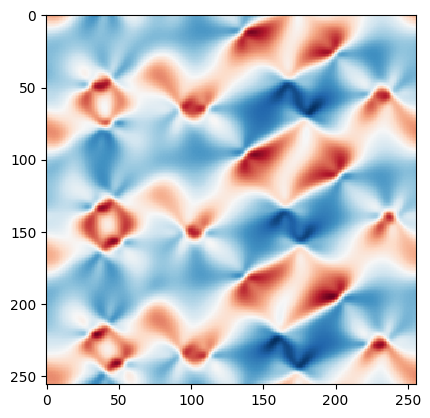

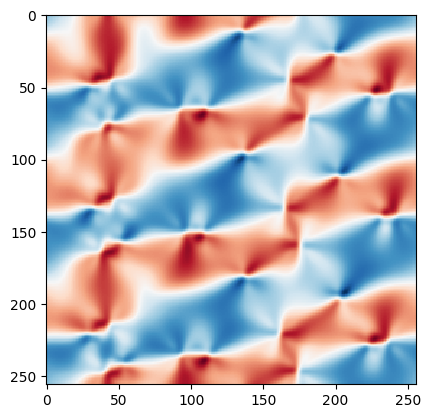

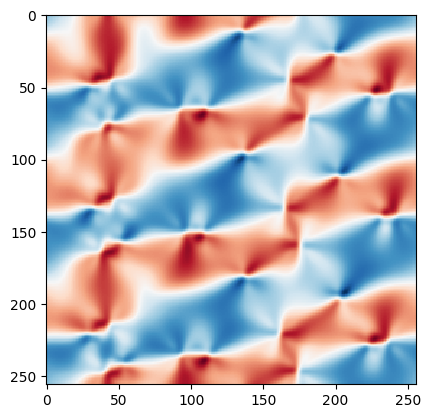

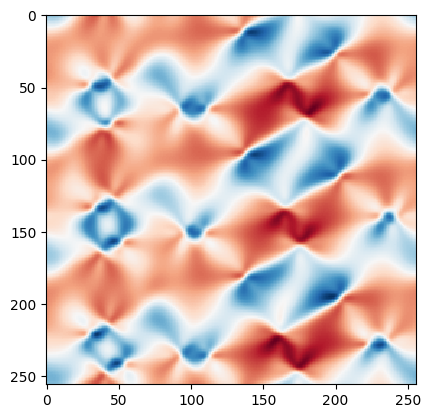

In [ ]:

x = dataset[train_idx[0]]['input_fields']
print(x.shape)
T, Lx, Ly, F = x.shape
ti = 10

plt.figure(figsize=(10, 5))
for i in range(11):
    img = x[ti,:,:, i]
    vmin = np.nanmin(img)
    vmax = np.nanmax(img)
    plt.imshow(img,cmap="RdBu_r",interpolation="none",vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.show()

FEATURE CALCULATION

In [ ]:


N = len(train_idx)
T = 81

mc = np.zeros((N, T), dtype=np.float32)
Ke = np.zeros((N, T), dtype=np.float32)
S = np.zeros((N, T), dtype=np.float32)
Srm = np.zeros((N, T), dtype=np.float32)
N_o = np.zeros((N, T), dtype=np.float32)
C_c = np.zeros((N, T), dtype=np.float32)

for i in range(N):

    item = dataset[train_idx[i]]
    x    = item['input_fields']

    for t in range(T):
        c  = x[t, :, :, 0].mean()

        vx = x[t, :, :, 1]
        vy = x[t, :, :, 2]
        ke = 0.5 * ( (vx**2 + vy**2).mean() )

        dxx = x[t, :, :, 3]
        dxy = x[t, :, :, 4]
        dyx = x[t, :, :, 5]
        dyy = x[t, :, :, 6]
        Si = ((dxx*vy - dyy*vx)**2).mean()

        Exx = x[t, :, :, 7]
        Exy = x[t, :, :, 8]
        Eyx = x[t, :, :, 9]
        Eyy = x[t, :, :, 10]
        smr = np.sqrt(Exx**2 + 2*Exy*Eyx + Eyy**2).mean()
        no = np.sqrt(dxx**2 + dxy**2 + dyx**2 + dyy**2).mean()

        cc = (vx*dxx + vy*dyx).mean()

        mc[i, t] = c
        Ke[i, t] = ke
        S[i,t] = Si
        Srm[i,t] = smr
        N_o[i,t] = no
        C_c[i,t] = cc

/tmp/ipykernel_9097/602541751.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  smr = np.sqrt(Exx**2 + 2*Exy*Eyx + Eyy**2).mean()
/tmp/ipykernel_9097/602541751.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  no = np.sqrt(dxx**2 + dxy**2 + dyx**2 + dyy**2).mean()


HISTOGRAM FOR EACH FEATURE ACRROS THE NUMBER OF SIMULATIONS:
we need to choose the time

In [ ]:
from ipywidgets import interact

def plot_hists(T):
    fig, ax = plt.subplots(1, 3, figsize=(12,4))

    ax[0].hist(Ke[:, T], bins=30)
    ax[0].set_title(f"Ke[:, {T}]")

    ax[1].hist(S[:, T], bins=30)
    ax[1].set_title(f"S[:, {T}]")

    ax[2].hist(Srm[:, T], bins=30)
    ax[2].set_title(f"Srm[:, {T}]")
    plt.tight_layout()
    plt.show()

interact(plot_hists, T=(0, Ke.shape[1]-1))

interactive(children=(IntSlider(value=40, description='T', max=80), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_hists(T)>

In [ ]:
def plot_hists(T):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    ax[0].hist(N_o[:, T], bins=30)
    ax[0].set_title(f"N_o[:, {T}]")

    ax[1].hist(C_c[:, T], bins=30)
    ax[1].set_title(f"C_c[:, {T}]")

    plt.tight_layout()
    plt.show()

interact(plot_hists, T=(0, Ke.shape[1]-1))

interactive(children=(IntSlider(value=40, description='T', max=80), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_hists(T)>

In [ ]:

T = np.linspace(0,80,81,dtype=int)

def plot(n_s):
    fig, ax = plt.subplots(1, 4, figsize=(12,4))


    ax[0].plot(T,mc[n_s, :])
    ax[0].set_title(f"mc[{n_s},:]")

    ax[1].plot(T,Ke[n_s, :])
    ax[1].set_title(f"Ke[{n_s},:]")

    ax[2].plot(T,S[n_s, :])
    ax[2].set_title(f"S[{n_s},:]")

    ax[3].plot(T,Srm[n_s, :])
    ax[3].set_title(f"Srm[{n_s},:]")

    plt.tight_layout()
    plt.show()

interact(plot, n_s=(0, Ke.shape[0]-1))

interactive(children=(IntSlider(value=69, description='n_s', max=139), Output()), _dom_classes=('widget-intera…

<function __main__.plot(n_s)>

In [ ]:


def plot(n_s):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))


    ax[0].plot(T,N_o[n_s, :])
    ax[0].set_title(f"N_o[{n_s},:]")

    ax[1].plot(T,C_c[n_s, :])
    ax[1].set_title(f"C_c[{n_s},:]")

    plt.tight_layout()
    plt.show()

interact(plot, n_s=(0, Ke.shape[0]-1))

interactive(children=(IntSlider(value=69, description='n_s', max=139), Output()), _dom_classes=('widget-intera…

<function __main__.plot(n_s)>

AUTOENCODER

In [ ]:
train_dataset = WellDataset(
    well_base_path="/home/itachi/Desktop/msc/data/datasets",
    well_dataset_name="active_matter",
    well_split_name="train",
    n_steps_input=1,
    n_steps_output=0,
    use_normalization=True,

)

eval_dataset = WellDataset(
    well_base_path="/home/itachi/Desktop/msc/data/datasets",
    well_dataset_name="active_matter",
    well_split_name="valid",
    n_steps_input=1,
    n_steps_output=0,
    use_normalization=True,

)

test_dataset = WellDataset(
    well_base_path="/home/itachi/Desktop/msc/data/datasets",
    well_dataset_name="active_matter",
    well_split_name="test",
    n_steps_input=1,
    n_steps_output=0,
    use_normalization=True,

)

In [ ]:
print(len(train_dataset))
item = train_dataset[0]
print(item['input_fields'].shape)
print(len(eval_dataset))
item2 = eval_dataset[0]
print(item2['input_fields'].shape)


14175
torch.Size([1, 256, 256, 11])
1944
torch.Size([1, 256, 256, 11])


AUTOENCODER 2D


Step 2: Loading the Dataset


In [ ]:

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
eval_loader  = torch.utils.data.DataLoader(eval_dataset,  batch_size=256, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=256, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Eval samples:  {len(eval_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

Train samples: 14175
Eval samples:  1944


In [ ]:
train_loader.dataset[0]['input_fields'].shape

torch.Size([1, 256, 256, 11])

In [ ]:
temp  = train_loader.dataset[0]['input_fields'].squeeze()
print(temp.shape)

In [ ]:
eval_loader.dataset[0]['input_fields'].shape

torch.Size([1, 256, 256, 11])

Step 3: Define the Autoencoder Model

In this step we are going to define our autoencoder. It consists of two components:

Encoder: Compresses the 784-pixel image into a smaller latent representation through fully connected layers with ReLU activations helps in reducing dimensions.

256*256*11 = 720896 ==> 128 ==> 64 ==> 36 ==> 18 ==> 9


Decoder: Reconstructs the original image by expanding the latent vector back to the original size, ending with a Sigmoid activation to output pixel values between 0 and 1

9 ==> 18 ==> 36 ==> 64 ==> 128 ==> 720896 ==> 256*256*11 = 720896

In [ ]:
class AE(nn.Module):
    def __init__(self, latent_dim=256):
        super(AE, self).__init__()

        # -------------- ENCODER --------------
        self.encoder_conv = nn.Sequential(
            # 256 -> 128
            nn.Conv2d(11, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 128 -> 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 64 -> 32
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 32 -> 16
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 256 → 128 → 64 → 32
        )
        # Ahora la forma es (B, 256, 16, 16)
        self.enc_out_channels = 256
        self.enc_out_h = 16
        self.enc_out_w = 16
        enc_flat_dim = self.enc_out_channels * self.enc_out_h * self.enc_out_w

        # Cuello de botella (vector latente)
        self.fc_enc = nn.Linear(enc_flat_dim, latent_dim)

        # -------------- DECODER --------------
        self.fc_dec = nn.Linear(latent_dim, enc_flat_dim)

        self.decoder_conv = nn.Sequential(
                # 16 -> 32
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2,
                            padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2,
                               padding=1, output_padding=1),  # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,
                               padding=1, output_padding=1),  # 64 -> 128
            nn.ReLU(),
            nn.ConvTranspose2d(32, 11, kernel_size=3, stride=2,
                               padding=1, output_padding=1),  # 128 -> 256
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_conv(x)                  # (B, 128, 32, 32)
        h = h.view(x.size(0), -1)                 # (B, enc_flat_dim)
        z = self.fc_enc(h)                        # (B, latent_dim)
        return z

    def decode(self, z):
        h = self.fc_dec(z)                        # (B, enc_flat_dim)
        h = h.view(-1, self.enc_out_channels,
                   self.enc_out_h, self.enc_out_w)  # (B, 128, 32, 32)
        xr = self.decoder_conv(h)                 # (B, 11, 256, 256)
        return xr

    def forward(self, x):
        z = self.encode(x)
        xr = self.decode(z)
        return xr, z

Step 4: Initializing Model

After defining the autoencoder, we create an instance of the model. We use Mean Squared Error (MSE) as the loss function since it measures how close the reconstructed images are to the original inputs. For optimization, we use the Adam optimizer with a learning rate of 0.001 and weight decay of 10e-8 which helps to prevent overfitting.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(latent_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-8)

In [ ]:
!! TODO

criterion = nn.MSELoss() + lamda1*LossD() + lamda2*LossC()

function : LossD()

Dxy = pred[4,:,:]
Dyx = pred[5,:,:]

retunr np.mean((Dxy-Dyx)**2)



Step 5: Training the model and Plotting Training Loss

In this step the model undergoes training for 20 epochs. The training process updates the model's weights using backpropagation and optimization techniques. Loss values are recorded during each iteration and after training a loss plot is generated to assess the model’s performance over time.

for batch in loader
Lee los datos por lotes
model(x)
Calcula la reconstrucción
loss = MSE(xr, x)
Mide el error de reconstrucción
loss.backward()
Calcula gradientes
optimizer.step()
Actualiza pesos
running += loss.item()
Acumula el error
epoch_loss = running / len(loader)
Promedia el error del epoch
losses.append(epoch_loss)
Guarda para graficar
plt.plot(losses)
Muestra la convergencia


Epoch 1/120 | Train Loss: 0.327514 | Val Loss: 0.252402
Epoch 2/120 | Train Loss: 0.216113 | Val Loss: 0.155566
Epoch 3/120 | Train Loss: 0.166721 | Val Loss: 0.145313
Epoch 4/120 | Train Loss: 0.164049 | Val Loss: 0.144555
Epoch 5/120 | Train Loss: 0.163562 | Val Loss: 0.144199
Epoch 6/120 | Train Loss: 0.162805 | Val Loss: 0.143947
Epoch 7/120 | Train Loss: 0.162833 | Val Loss: 0.143772
Epoch 8/120 | Train Loss: 0.162580 | Val Loss: 0.143638
Epoch 9/120 | Train Loss: 0.162587 | Val Loss: 0.143548
Epoch 10/120 | Train Loss: 0.162452 | Val Loss: 0.143474
Epoch 11/120 | Train Loss: 0.162290 | Val Loss: 0.143405
Epoch 12/120 | Train Loss: 0.162365 | Val Loss: 0.143337
Epoch 13/120 | Train Loss: 0.162111 | Val Loss: 0.143189
Epoch 14/120 | Train Loss: 0.162036 | Val Loss: 0.142888
Epoch 15/120 | Train Loss: 0.161472 | Val Loss: 0.142503
Epoch 16/120 | Train Loss: 0.161136 | Val Loss: 0.141899
Epoch 17/120 | Train Loss: 0.160673 | Val Loss: 0.141328
Epoch 18/120 | Train Loss: 0.159839 | Va

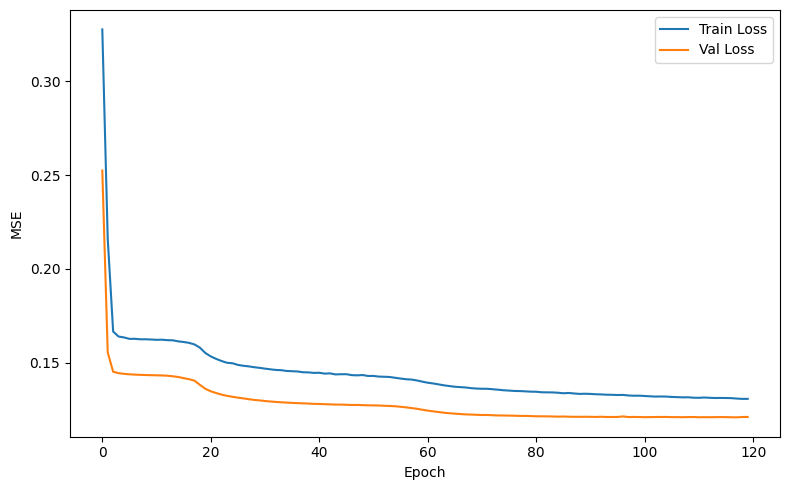

In [ ]:
epochs = 200
train_losses = []
val_losses = []
patience = 5

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # -----------------------
    # Fase de ENTRENAMIENTO
    # -----------------------
    model.train()
    running_train = 0.0

    for batch in train_loader:
        # batch["input_fields"]: (B, 1, 256, 256, 11)
        x = batch["input_fields"].to(device)

        # quitar la dimensión de tiempo (n_steps_input=1)
        #x = x[:, 0]  # (B, 256, 256, 11)
        x = x.squeeze()  # (B, 256, 256, 11)

        # reordenar a (B, C, H, W) = (B, 11, 256, 256)
        x = x.permute(0, 3, 1, 2).contiguous()

        # forward
        xr, z = model(x)

        # loss
        loss = criterion(xr, x)

        # backward
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        running_train += loss.item()

    epoch_train_loss = running_train / len(train_loader)
    train_losses.append(epoch_train_loss)

    # -----------------------
    # Fase de VALIDACIÓN
    # -----------------------
    model.eval()
    running_val = 0.0

    with torch.no_grad():
        for batch in eval_loader:
            x = batch["input_fields"].to(device)
            #x = x[:, 0]                       # (B, 256, 256, 11)
            x = x.squeeze()
            x = x.permute(0, 3, 1, 2).contiguous()  # (B, 11, 256, 256)

            xr, z = model(x)
            val_loss = criterion(xr, x)
            running_val += val_loss.item()

    epoch_val_loss = running_val / len(eval_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.6f} | "
          f"Val Loss: {epoch_val_loss:.6f}")


    # -----------------------
    # EARLY STOPPING AQUÍ
    # -----------------------
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1

# -----------------------
# Curvas de pérdida
# -----------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------
# 5) Guardar el modelo entrenado
# -----------------------------------
torch.save(model.state_dict(), "autoencoder_active_matter3.pth")
print("✅ Modelo guardado como 'autoencoder_active_matter3.pth'")

✅ Modelo guardado como 'autoencoder_active_matter3.pth'


In [ ]:
model = AE()
model.load_state_dict(torch.load("autoencoder_active_matter3.pth"))
model.to(device)
model.eval()

AE(
  (encoder_conv): Sequential(
    (0): Conv2d(11, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_enc): Linear(in_features=65536, out_features=8, bias=True)
  (fc_dec): Linear(in_features=8, out_features=65536, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padd

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()
# #del model
# #del train_dataset
# # del eval_dataset

In [ ]:
# for obj in gc.get_objects():
#     try:
#         if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#             if obj.is_cuda:
#                 print(type(obj), obj.size())
#     except:
#         pass

In [ ]:
# xti = []
# xto = []
with torch.no_grad():
    for batch in test_loader:
        x = batch["input_fields"].to(device)
        x = x.squeeze()                      # (B, 256, 256, 11)
        x = x.permute(0, 3, 1, 2).contiguous()  # (B, 11, 256, 256)
        #xti.append(x)
        xr, z = model(x)
        #xto.append(xr)
        val_loss = criterion(xr, x)


!! VRMSE.eval(fx, y, meta=validset.metadata)

In [ ]:
print(x.shape, xr.shape)

torch.Size([152, 11, 256, 256]) torch.Size([152, 11, 256, 256])


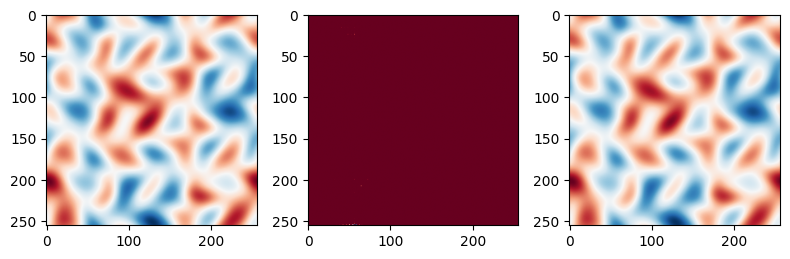

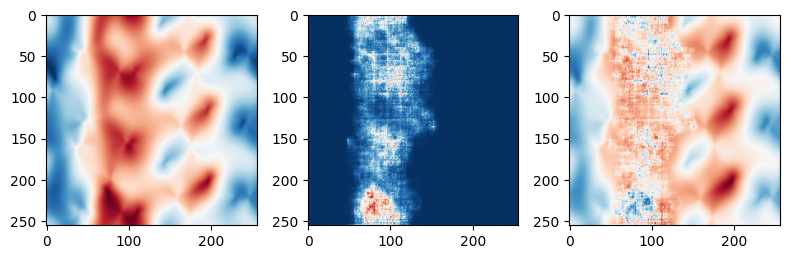

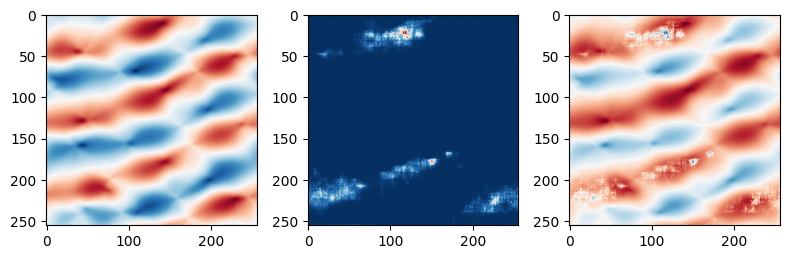

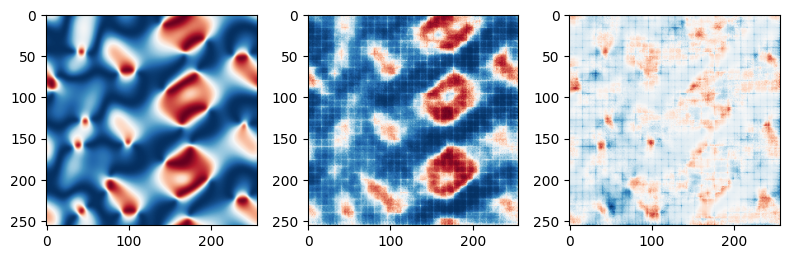

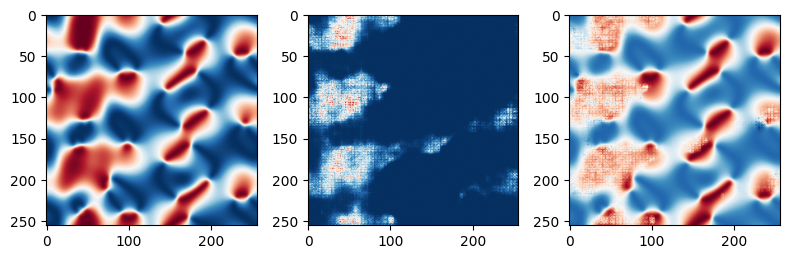

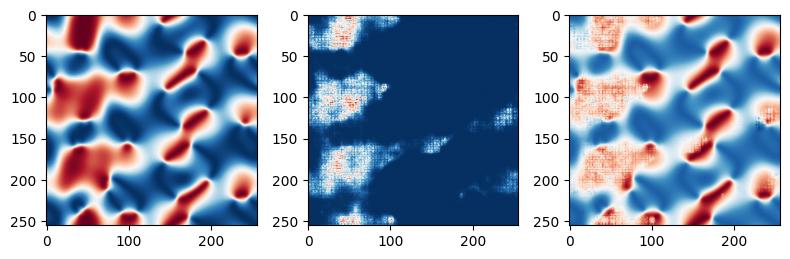

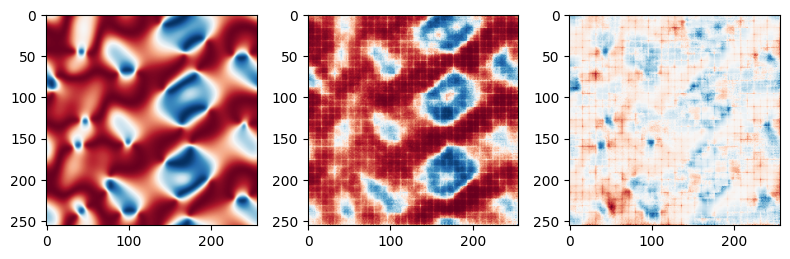

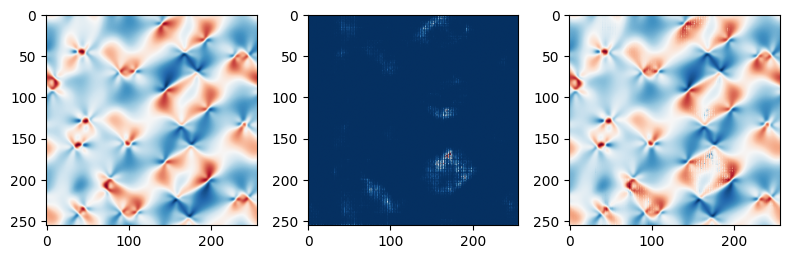

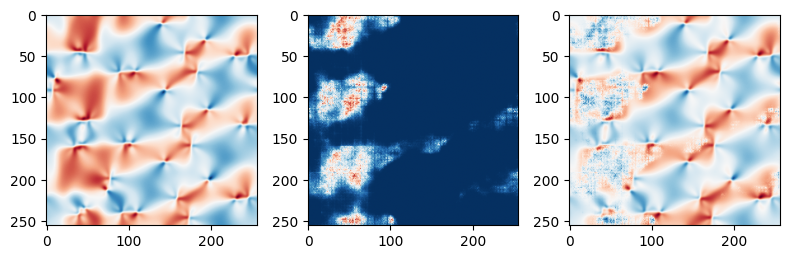

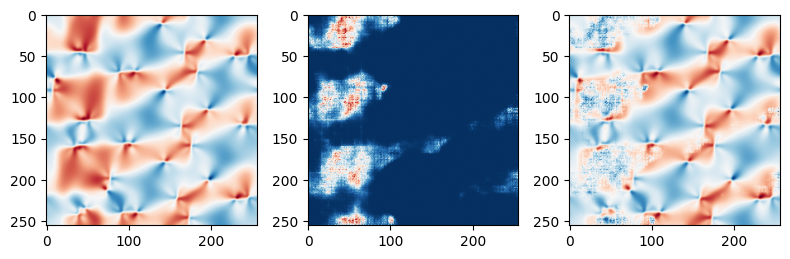

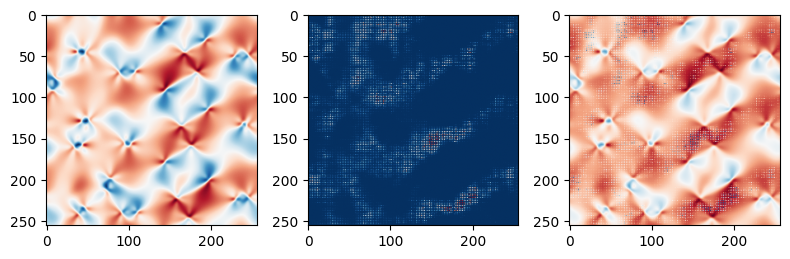

In [ ]:
sim = 1
for i in range(11):
    img = x[sim,i,:,:].detach().cpu().numpy()
    imgr = xr[sim,i,:,:].detach().cpu().numpy()
    plt.figure(figsize=(8,4))

    plt.subplot(1,3,1)
    plt.imshow(img,cmap="RdBu_r")

    plt.subplot(1,3,2)
    plt.imshow(imgr,cmap="RdBu_r")

    plt.subplot(1,3,3)
    plt.imshow(img-imgr,cmap="RdBu_r")

    plt.tight_layout()
    plt.show()

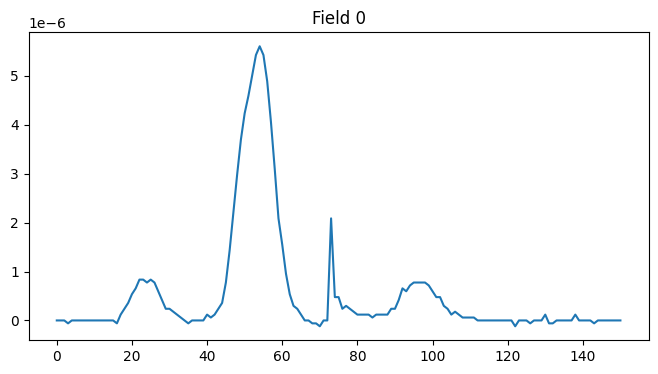

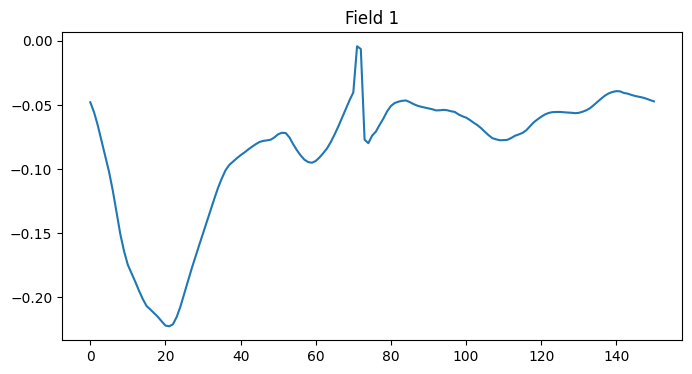

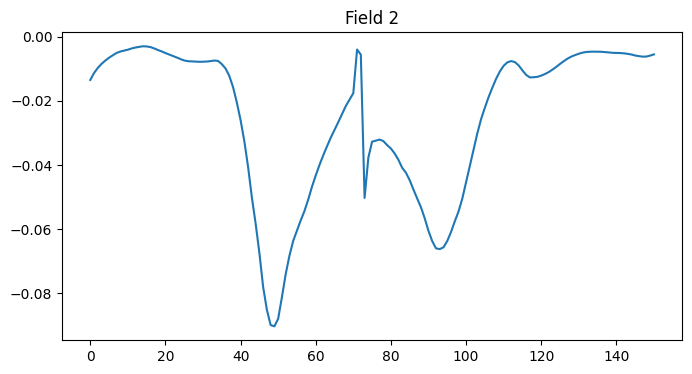

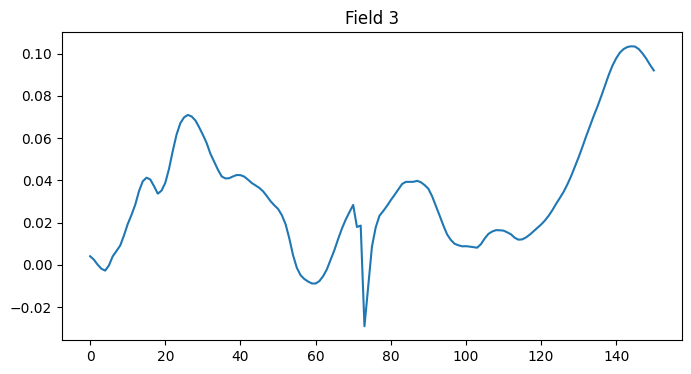

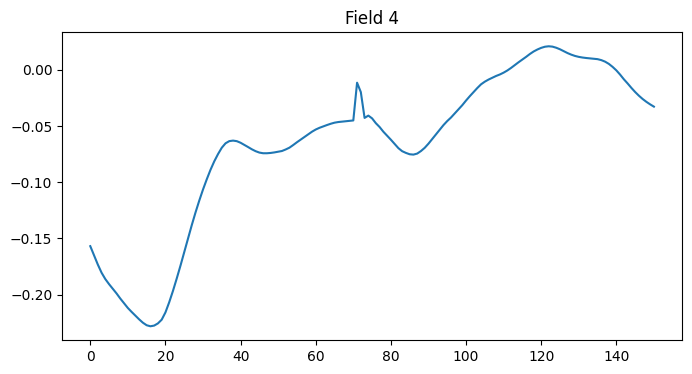

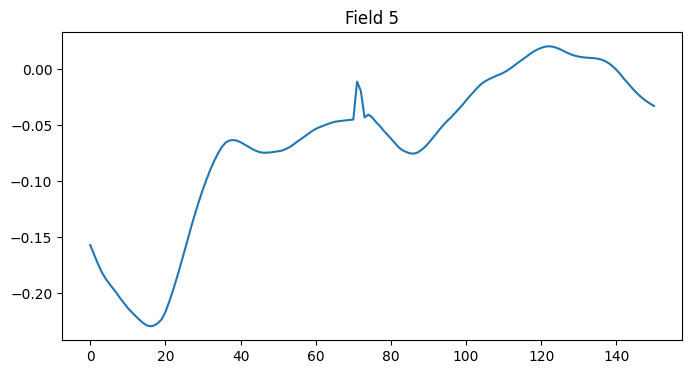

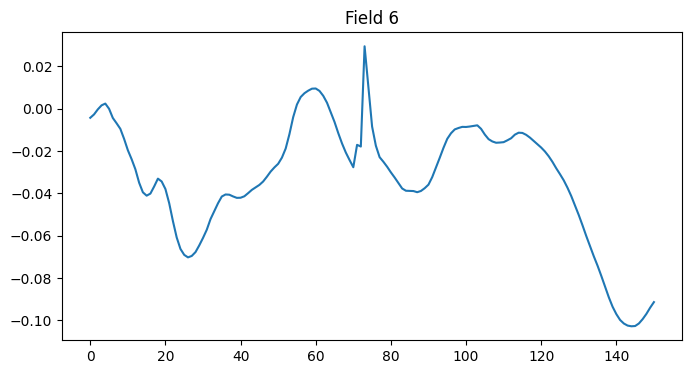

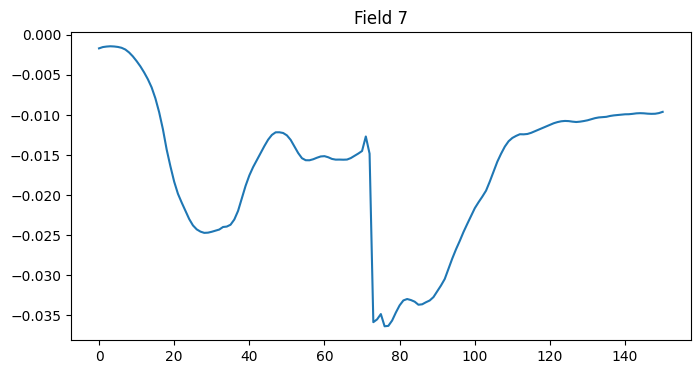

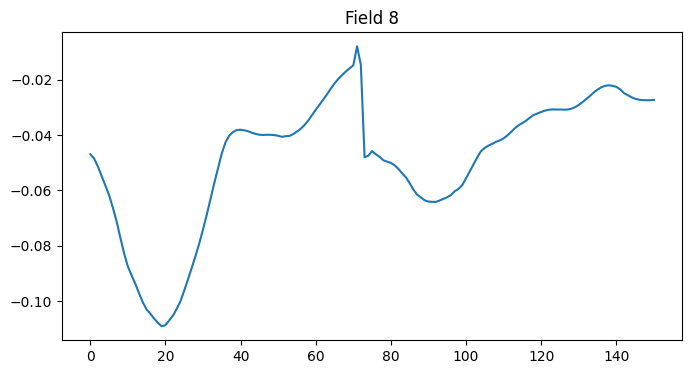

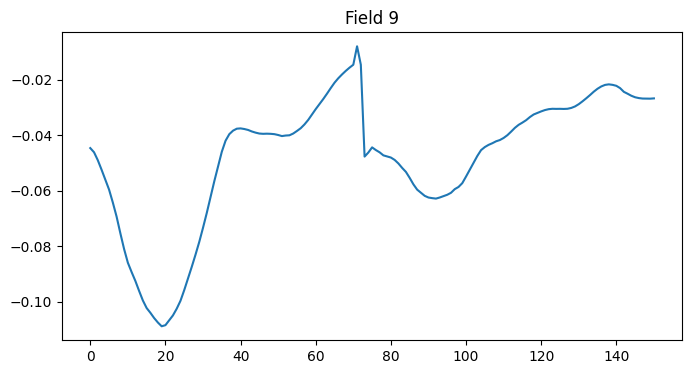

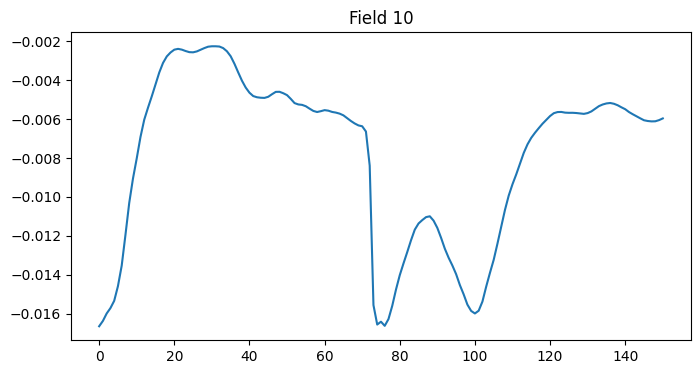

In [ ]:
for j in range(11):
    plt.figure(figsize=(8,4))
    a = []
    for i in range(151):
        img = x[i,j,:,:].detach().cpu().numpy().mean()
        imgr = xr[i,j,:,:].detach().cpu().numpy().mean()
        a.append(np.mean((img-imgr)**2))

    plt.plot(a)
    plt.title(f"Field {j}")
    plt.show()


In [ ]:
# import torch
# import numpy as np

# model.eval()  # modo evaluación (desactiva dropout, etc.)
# Z = []        # lista donde guardaremos todos los vectores latentes

# with torch.no_grad():  # sin gradientes = más rápido y menos memoria
#     for batch in loader:
#         x = batch["input_fields"].to(device)   # (B, 1,256,256,11)
#         _, z = model(x)                        # obtenemos la salida latente
#         Z.append(z.detach().cpu().numpy())     # pasamos a numpy y CPU

# # concatenar todos los lotes
# Z = np.concatenate(Z, axis=0)  # (N, 9)
# print("Espacio latente total:", Z.shape)

# # guardar a disco
# np.save("latent_space.npy", Z)
# print("Espacio latente guardado en latent_space.npy")

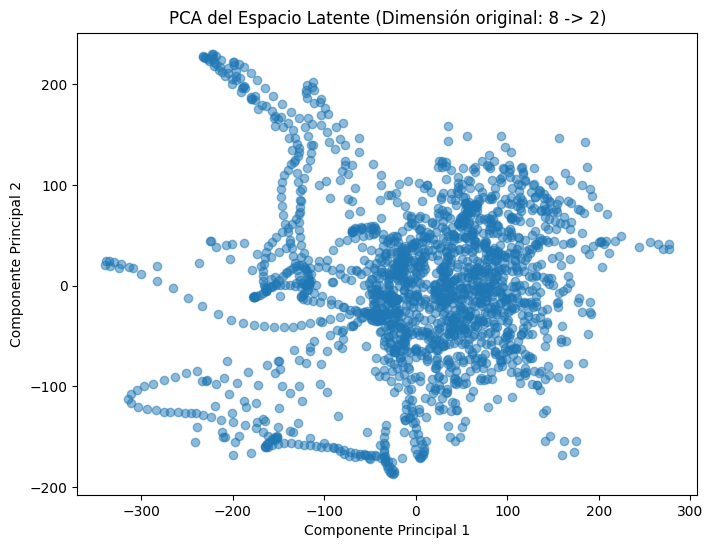

In [ ]:
from sklearn.decomposition import PCA

ze = []
model.eval()

with torch.no_grad():
    for batch in eval_loader:
        x = batch["input_fields"].to(device)
        x = x[:, 0]
        x = x.permute(0, 3, 1, 2).contiguous()

        xr, z = model(x)

        # CORRECCIÓN: Mover a CPU inmediatamente para liberar VRAM
        # z tiene forma (Batch, 8), así que está listo para guardar
        ze.append(z.cpu())

# 1. Concatenar la lista de tensores en un solo tensor grande (N, 8)
Z_tensor = torch.cat(ze, dim=0)

# 2. Convertir a Numpy
X = Z_tensor.numpy()

# 3. Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 4. Graficar
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title(f"PCA del Espacio Latente (Dimensión original: {X.shape[1]} -> 2)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

In [ ]:


N = 1943
T = 1

mc = np.zeros((N, T), dtype=np.float32)
Ke = np.zeros((N, T), dtype=np.float32)
S = np.zeros((N, T), dtype=np.float32)
Srm = np.zeros((N, T), dtype=np.float32)
N_o = np.zeros((N, T), dtype=np.float32)
C_c = np.zeros((N, T), dtype=np.float32)

for i in range(N):

    item = eval_dataset[i]
    x    = item['input_fields']

    for t in range(T):
        c  = x[t, :, :, 0].mean()

        vx = x[t, :, :, 1]
        vy = x[t, :, :, 2]
        ke = 0.5 * ( (vx**2 + vy**2).mean() )

        dxx = x[t, :, :, 3]
        dxy = x[t, :, :, 4]
        dyx = x[t, :, :, 5]
        dyy = x[t, :, :, 6]
        Si = ((dxx*vy - dyy*vx)**2).mean()

        Exx = x[t, :, :, 7]
        Exy = x[t, :, :, 8]
        Eyx = x[t, :, :, 9]
        Eyy = x[t, :, :, 10]
        smr = np.sqrt(Exx**2 + 2*Exy*Eyx + Eyy**2).mean()
        no = np.sqrt(dxx**2 + dxy**2 + dyx**2 + dyy**2).mean()

        cc = (vx*dxx + vy*dyx).mean()

        mc[i, t] = c
        Ke[i, t] = ke
        S[i,t] = Si
        Srm[i,t] = smr
        N_o[i,t] = no
        C_c[i,t] = cc

/tmp/ipykernel_9097/477726144.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  smr = np.sqrt(Exx**2 + 2*Exy*Eyx + Eyy**2).mean()
/tmp/ipykernel_9097/477726144.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  no = np.sqrt(dxx**2 + dxy**2 + dyx**2 + dyy**2).mean()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Extraer z para T el conjunto de entrenamiento (N simulaciones x T tiempos)
#    para que coincida con tus arrays de escalares (Ke, S, etc.)
Z_list = []

model.eval()
with torch.no_grad():
    for i in range(N):
        # Usamos el mismo índice que usaste para calcular los escalares
        idx = i
        item = eval_dataset[idx]

        # item['input_fields'] tiene forma (T, 256, 256, 11)
        # El modelo espera (Batch, Canales, H, W)
        # Convertimos T en la dimensión del Batch para procesar toda la serie temporal
        x_seq = item['input_fields'] # (81, 256, 256, 11)
        x_seq = x_seq.permute(0, 3, 1, 2).contiguous() # (81, 11, 256, 256)

        x_seq = x_seq.to(device)

        # Obtenemos z para los 81 pasos de tiempo de una vez
        # z_seq tendrá forma (81, 8)
        z_seq = model.encode(x_seq)

        Z_list.append(z_seq.cpu())




In [ ]:


# 2. Concatenar todo en una gran matriz (N*T, 8)
X_latente = torch.cat(Z_list, dim=0).numpy()

# 3. Aplanar tus escalares para que coincidan (N*T,)
#    Elige qué escalar quieres visualizar como "color" (ej. Energía Cinética)
mc_flat = c.flatten()
Ke_flat = Ke.flatten()
S_flat = S.flatten()
Srm_flat = Srm.flatten()
No_flat = N_o.flatten()
C_c_flat = C_c.flatten()

# 4. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_latente)

# 5. Graficar: Colorear por Energía Cinética (Ke)

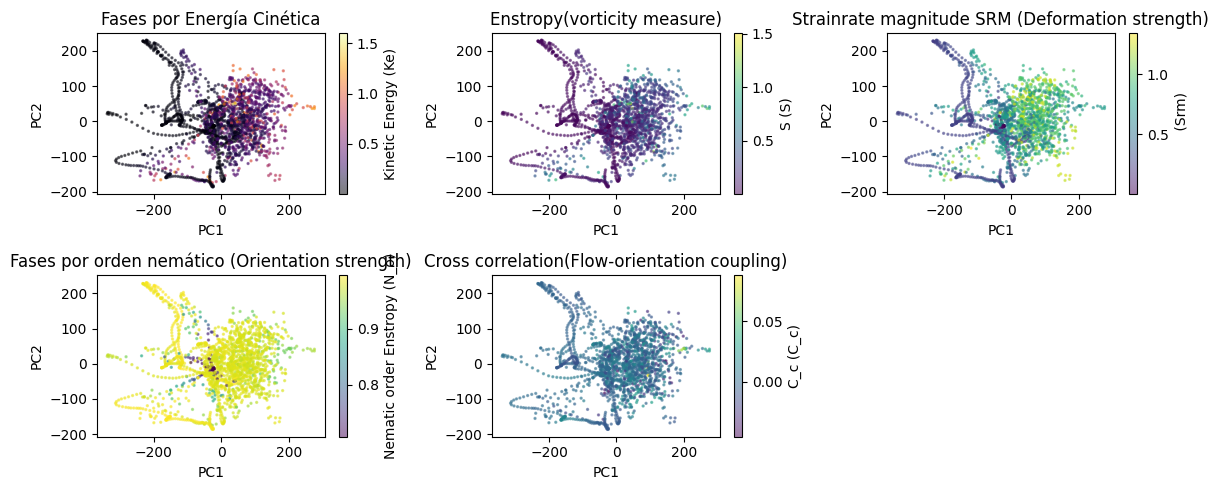

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(2, 3, 1)
sc1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Ke_flat, cmap='inferno', s=2, alpha=0.5)
plt.colorbar(sc1, label='Kinetic Energy (Ke)')
plt.title("Fases por Energía Cinética")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Graficar: Colorear por Enstrofia (N_o) u otro parámetro
plt.subplot(2, 3, 2)
sc2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=S_flat, cmap='viridis', s=2, alpha=0.5)
plt.colorbar(sc2, label='S (S)')
plt.title("Enstropy(vorticity measure)") #escalar derivado del tensor de deformacion
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(2, 3, 3)
sc2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Srm_flat, cmap='viridis', s=2, alpha=0.5)
plt.colorbar(sc2, label=' (Srm)')
plt.title("Strainrate magnitude SRM (Deformation strength)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(2, 3, 4)
sc2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=No_flat, cmap='viridis', s=2, alpha=0.5)
plt.colorbar(sc2, label='Nematic order Enstropy (N_o)')
plt.title("Fases por orden nemático (Orientation strength)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(2, 3, 5)
sc2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=C_c_flat, cmap='viridis', s=2, alpha=0.5)
plt.colorbar(sc2, label='C_c (C_c)')
plt.title("Cross correlation(Flow-orientation coupling)")
plt.xlabel("PC1")
plt.ylabel("PC2")



plt.tight_layout()
plt.show()